In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path(".")

In [4]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [5]:
fname = "2021_6_25.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1624635434 scan R0 F1 DET                                                        : 2321
1  <> 1624636492 scan P2 F1 with R0 F1 F1=3_2 DET                                      : 1181
2  <> 1624636858 scan P2 F1 ratio with R0 F1 F1=3_2 DET                                : 6241
3  <> 1624638236 scan R0 F2 F1=3_2                                                     : 3441
4  <> 1624639007 scan P2 F1 RC ratio with R0 F2 F1=3_2 DET and J12 and J23 microwaves  : 11201
5  <> 1624644505 scan R2 F4 F1=7_2                                                     : 1771
6  <> 1624644866 scan R2 F4 F1=7_2                                                     : 3361
7  <> 1624645713 scan microwave power with R2 F4 F1=7_2 DET                            : 1281
8  <> 1624646695 scan P2 F1 ratio with R2 F4 F1=7_2 DET                                : 6561
9  <> 1624648615 scan R3 F5 F1=9_2 DET                                                 : 241
10 <> 1624648785 scan R3 F5 F1=9_2 DET                      

### Single pass detection small beam

### All with phase modulation on detection

## Scan R0 F=1 F1'=1/2
38 mW

In [8]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [20]:
dset_idx = 0
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

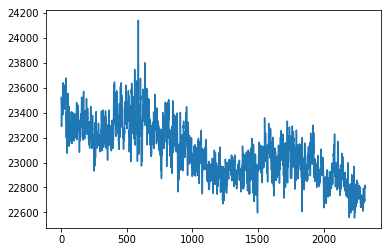

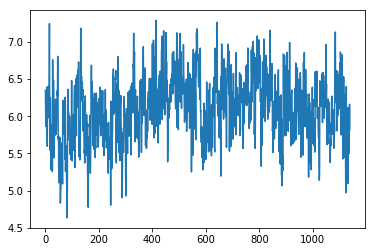

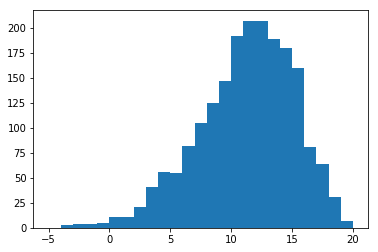

In [21]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [22]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [23]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

9.8% data discarded


In [24]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

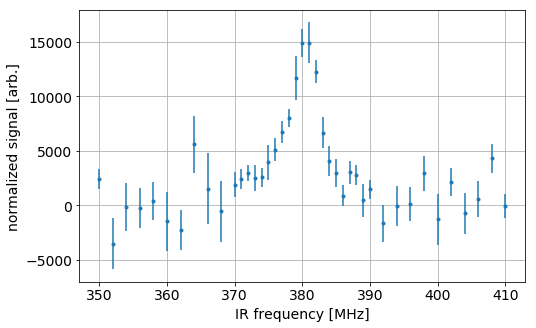

In [25]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 RC with R0 F=1 F1'=1/2 DET
38 mW DET  
68 mW RC

In [27]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [37]:
dset_idx = 1
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

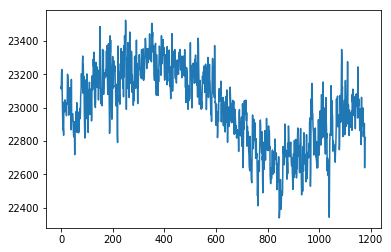

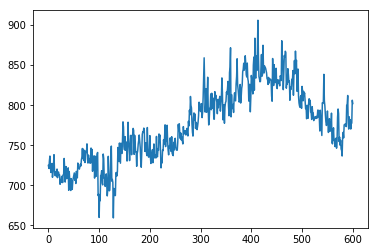

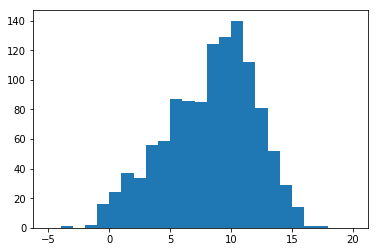

In [38]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [39]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [40]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

19.5% data discarded


In [41]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

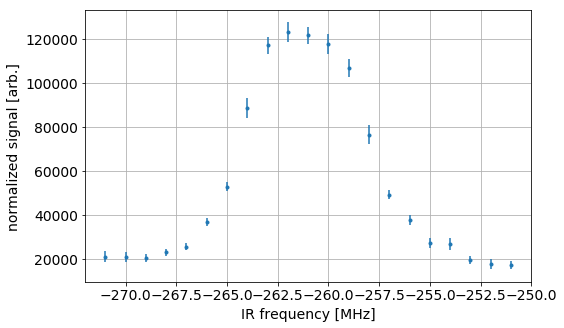

In [42]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 ratio with R0 F1 F1=3/2 DET and J12 & J23 microwaves
38 mW DET  
68 mW RC

In [128]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [129]:
dset_idx = 2
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

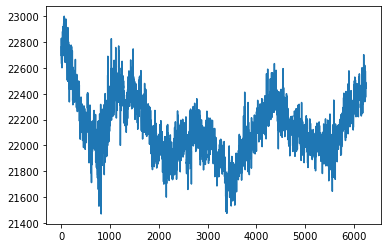

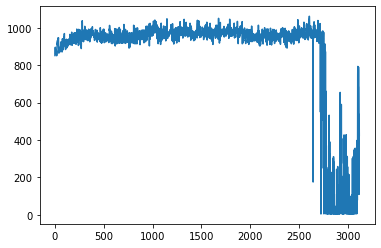

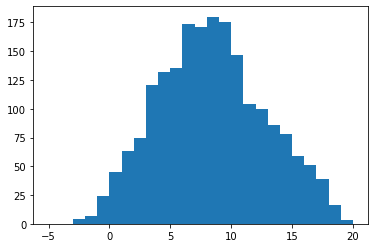

In [130]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [131]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 800

In [132]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

22.0% data discarded


In [133]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

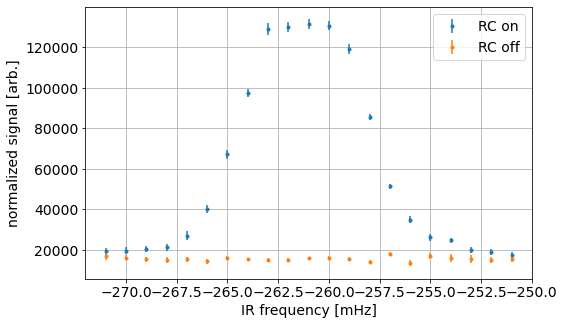

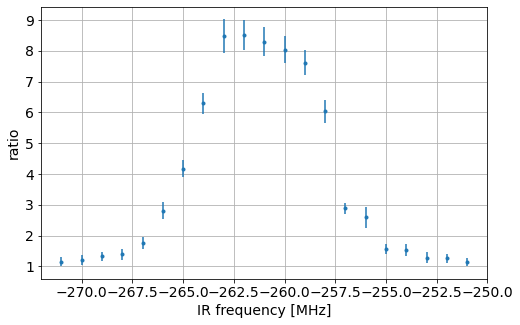

In [134]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [mHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [137]:
m = (bin_means == -263) | (bin_means == -262) | (bin_means == -261) | (bin_means == -260)
print(ratio[m].mean())
print(np.sqrt(np.sum(err[m]**2))/np.sqrt(m.sum()))

8.327890736307205
0.4827911017191717


## Scan R0 F2 F1=3/2 DET
38 mW DET  

In [27]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [94]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

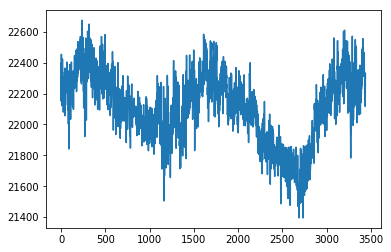

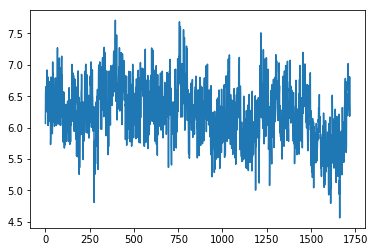

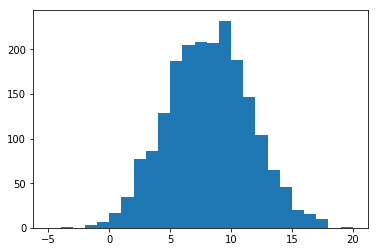

In [95]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [96]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [97]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

16.6% data discarded


In [98]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

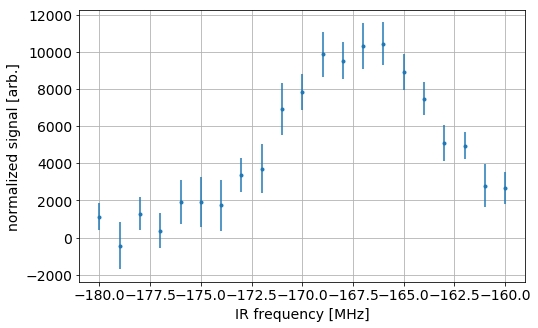

In [99]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 ratio with R0 F2 F1=3/2 DET and J12 & J23 microwaves
38 mW DET  
76 mW RC

In [255]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [256]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

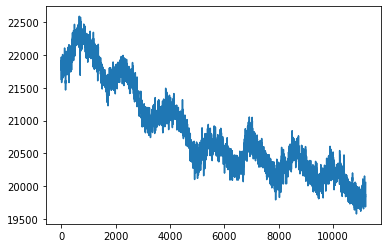

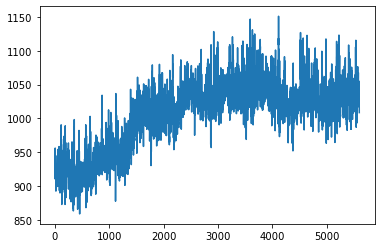

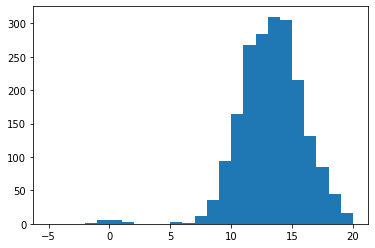

In [257]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [258]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 800

In [259]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.8% data discarded


In [260]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

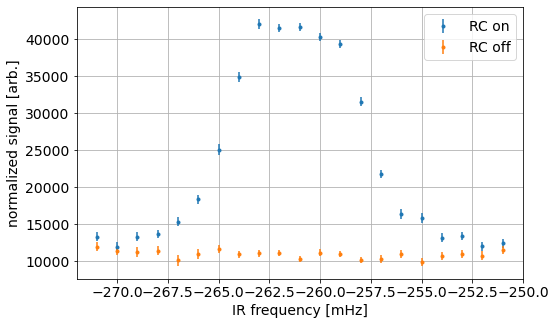

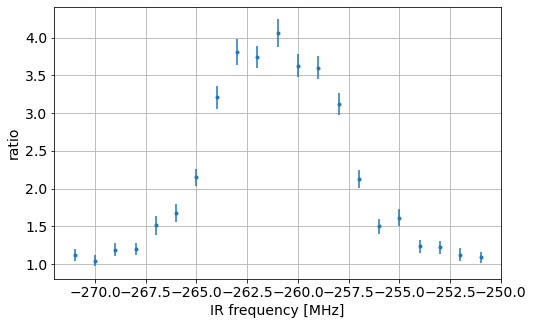

In [261]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [mHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [262]:
m = (bin_means == -263) | (bin_means == -262) | (bin_means == -261) | (bin_means == -260)
print(ratio[m].mean())
print(np.sqrt(np.sum(err[m]**2))/np.sqrt(m.sum()))

3.80963538961529
0.16563660146799047


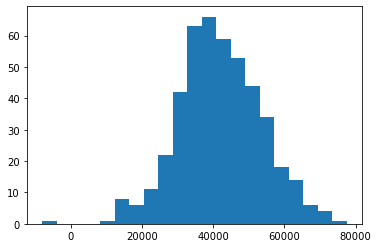

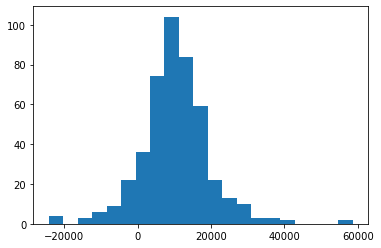

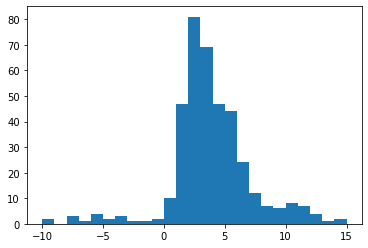

In [270]:
m = scan_parameters == -261
o = (fluorescence_integral/absorption_integral)[m & mask_sh_open]
# o = np.nanmean(o.reshape(-1,5), axis = 1)
c = (fluorescence_integral/absorption_integral)[m & mask_sh_closed]
# c = np.nanmean(c.reshape(-1,5), axis = 1)
plt.hist(o, bins = 21)

plt.figure()
plt.hist(c, bins = 21)

plt.figure()
plt.hist(o/c, np.linspace(-10,15,26));

## Scan R2 F4 F1=7/2 DET
35 mW DET  

In [24]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [25]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

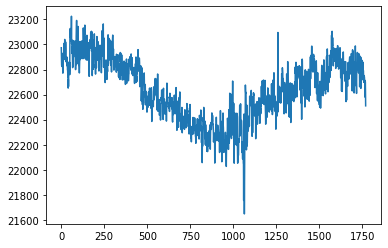

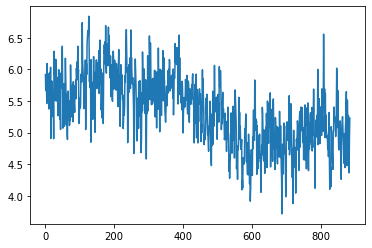

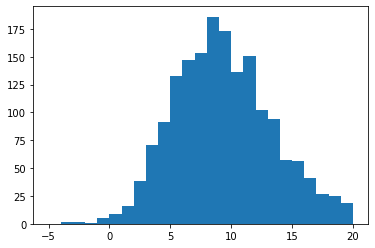

In [26]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [27]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [28]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

13.4% data discarded


In [29]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

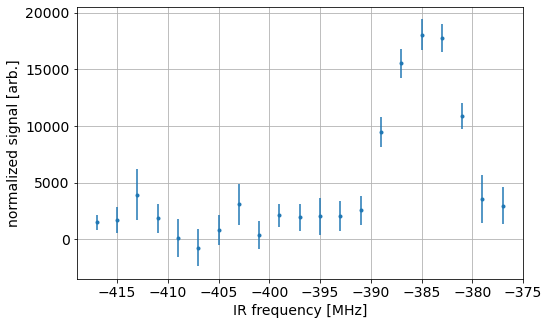

In [30]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan R2 F4 F1=7/2 DET
35 mW DET  

In [31]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [32]:
dset_idx = 6
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

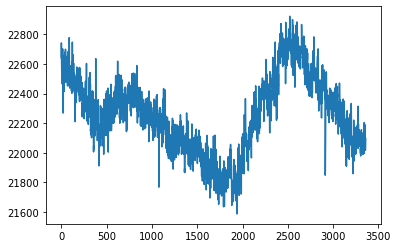

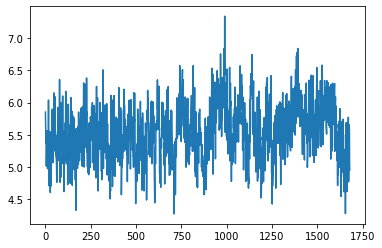

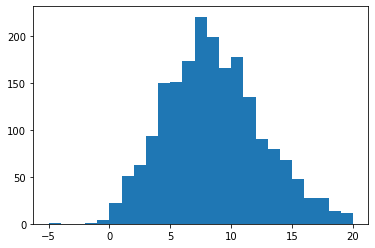

In [33]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [34]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [35]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

20.0% data discarded


In [36]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

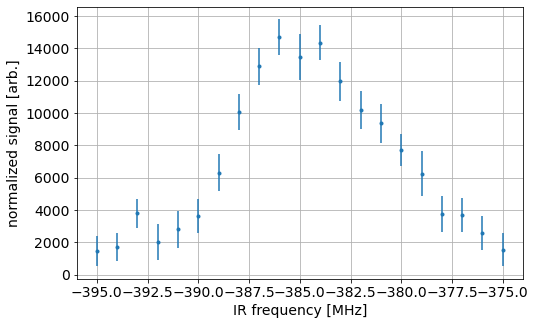

In [37]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

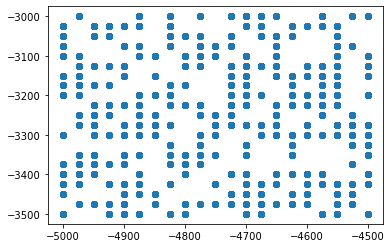

In [38]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan Microwave powers with R2 F4 F1=7/2 DET
34 mW DET

In [39]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [40]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'
scan_parameter2 = 'SynthHD Pro SetPowerCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
scan_parameters2 = np.array([float(pxie_attrs[idx][scan_parameter2]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters2 = np.append(scan_parameters2, np.array([float(pxie_attrs[idx][scan_parameter2]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

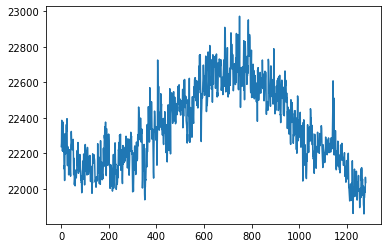

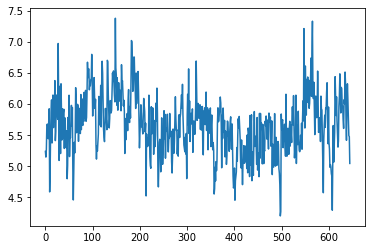

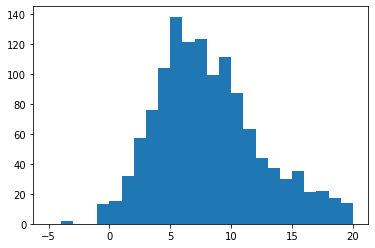

In [41]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [42]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [43]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

23.5% data discarded


In [44]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = (scan_parameters == f) & (scan_parameters2 == -25)
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

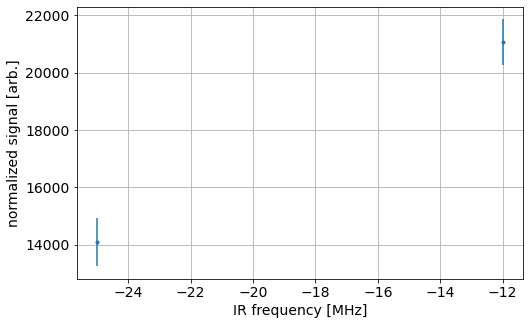

In [45]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [46]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = (scan_parameters == f) & (scan_parameters2 == -9.35)
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

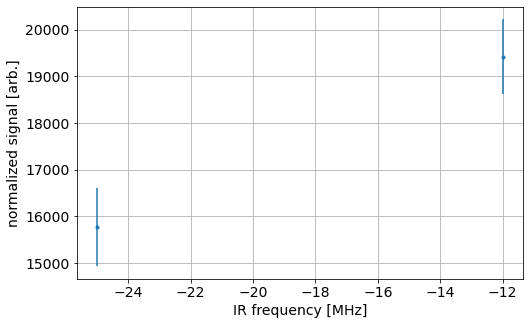

In [47]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

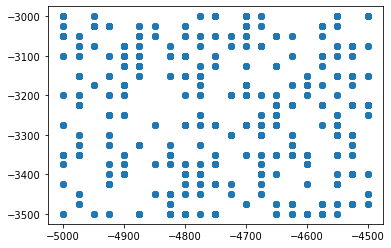

In [48]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan P2 F1 ratio with R2 F4 F1=7/2 DET and J12 & J23 microwaves
34 mW DET  
84 mW RC

In [49]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [50]:
dset_idx = 8
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

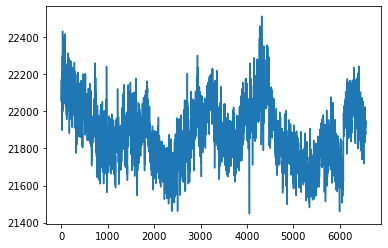

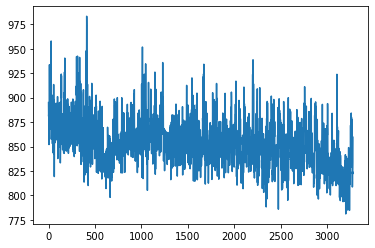

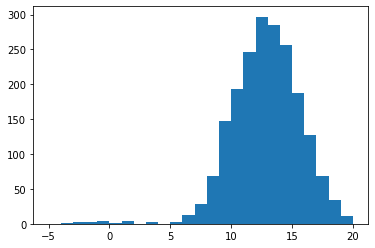

In [51]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [52]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 700

In [53]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

3.9% data discarded


In [54]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

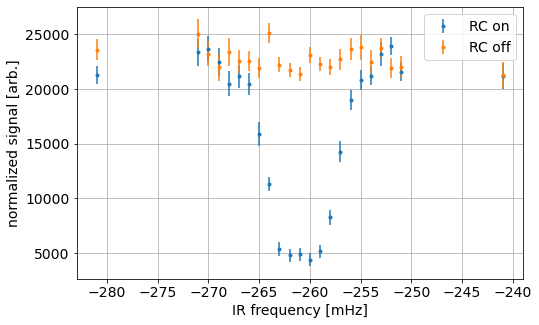

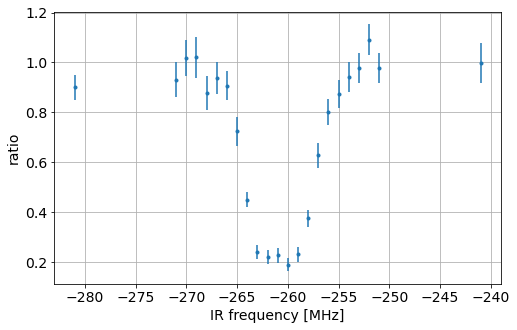

In [55]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [mHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

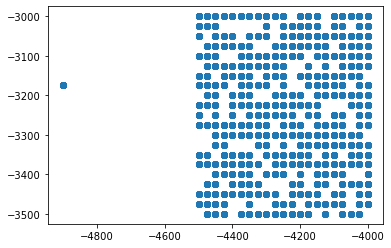

In [56]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

In [60]:
m = (bin_means == -263) | (bin_means == -262) | (bin_means == -261) | (bin_means == -260) | (bin_means == -259)
print(ratio[m].mean())
print(np.sqrt(np.sum(err[m]**2))/np.sqrt(m.sum()))

0.22143276737920128
0.028708424470179517


## Scan R3 F5 F1=9/2 DET
35 mW DET  

In [263]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [278]:
dset_idx = 10
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

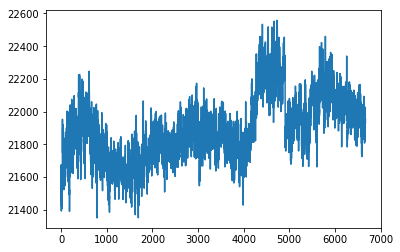

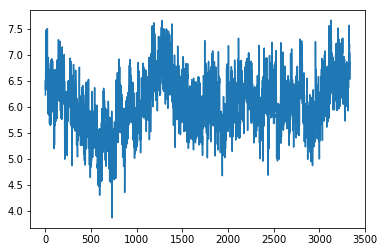

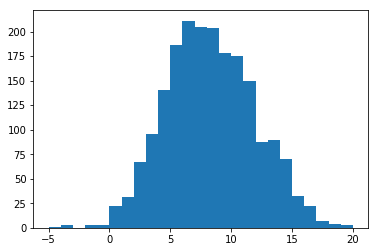

In [279]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [280]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [281]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

25.4% data discarded


In [282]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

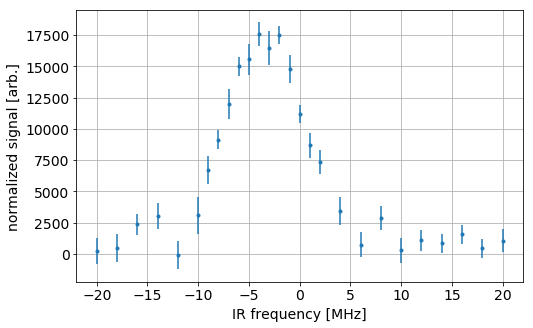

In [283]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

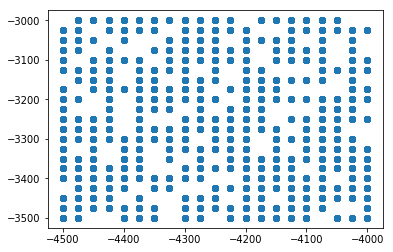

In [284]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan J23 microwave power with R3 F5 F1=9/2 DET
35 mW DET  

In [309]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [310]:
dset_idx = 11
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

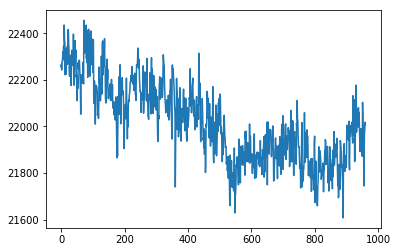

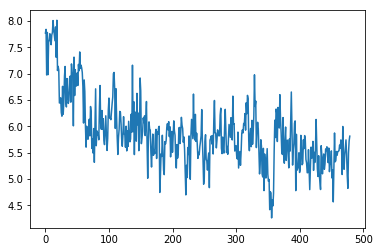

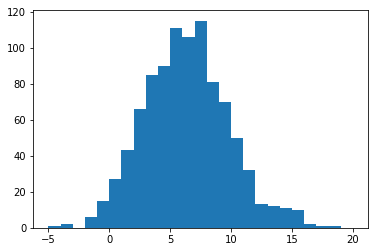

In [311]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [312]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [313]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

36.0% data discarded


In [314]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

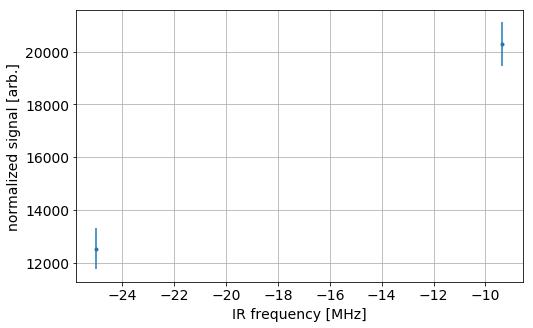

In [315]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

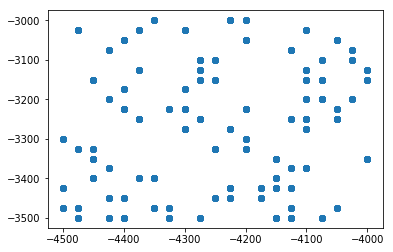

In [316]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan P2 F1 ratio with R3 F5 F1=9/2 DET and J12 & J23 microwaves
34 mW DET  
79 mW RC

In [61]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [62]:
dset_idx = 13
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

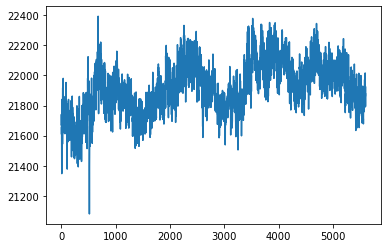

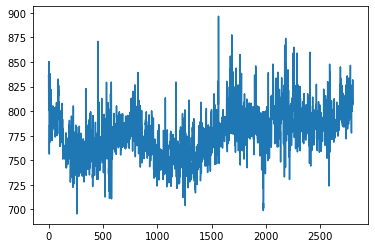

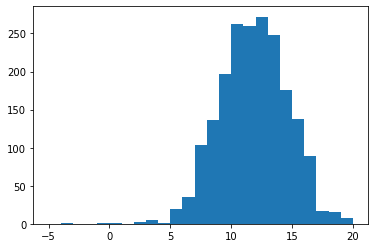

In [63]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [64]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 700

In [65]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

14.4% data discarded


In [66]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

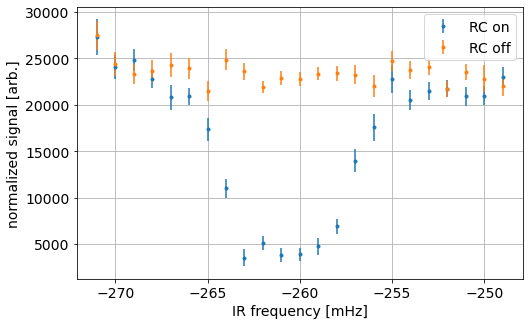

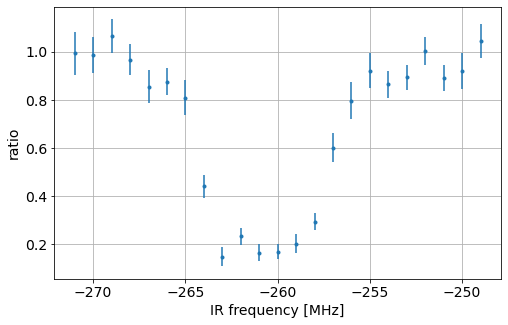

In [67]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [mHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

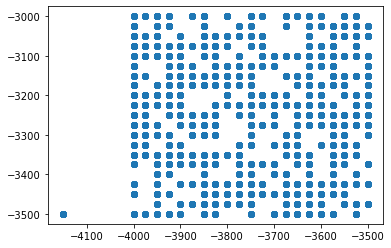

In [68]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

In [69]:
m = (bin_means == -263) | (bin_means == -262) | (bin_means == -261) | (bin_means == -260) | (bin_means == -259)
print(ratio[m].mean())
print(np.sqrt(np.sum(err[m]**2))/np.sqrt(m.sum()))

0.1843397101354662
0.036149851115457765


## Scan Microwave powers with R2 F4 F1=7/2 DET
34 mW DET

In [357]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [358]:
dset_idx = 14
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'
scan_parameter2 = 'SynthHD Pro SetPowerCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])
scan_parameters2 = np.array([float(pxie_attrs[idx][scan_parameter2]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters2 = np.append(scan_parameters2, np.array([float(pxie_attrs[idx][scan_parameter2]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

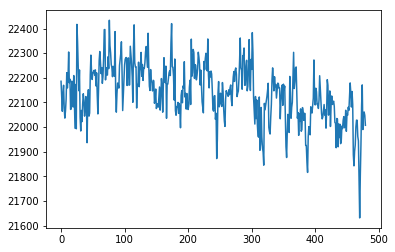

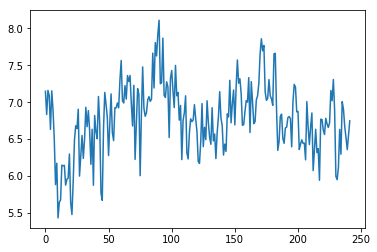

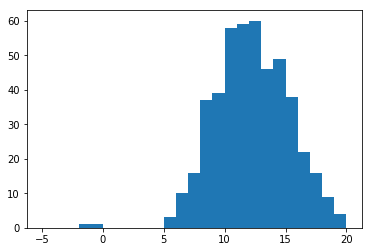

In [359]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [360]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [361]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.6% data discarded


In [362]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = (scan_parameters == f) & (scan_parameters2 == -25)
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

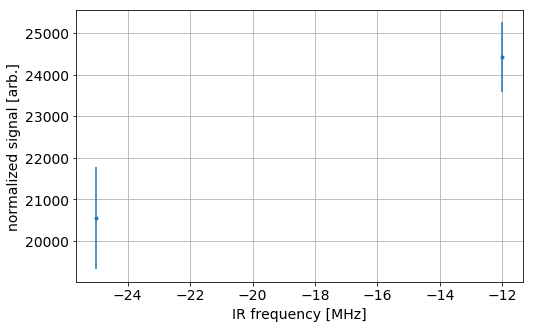

In [363]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [364]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = (scan_parameters == f) & (scan_parameters2 == -9.35)
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

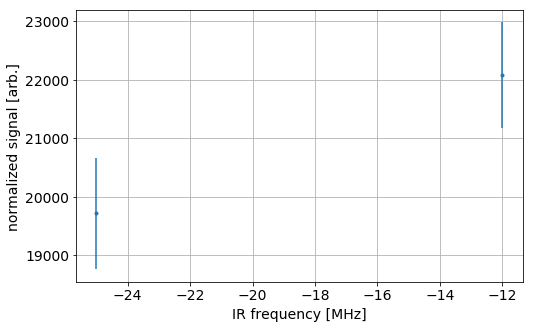

In [365]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

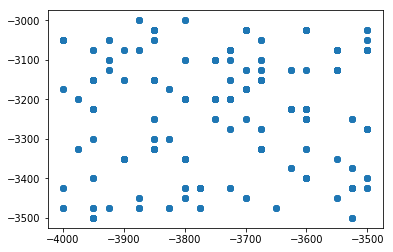

In [366]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan microwave powers with R2 F4 F1=7/2 DET
35 mW DET  

In [481]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [482]:
dset_idx = 15
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM','SynthHD Pro')
scan_parameter = 'PXIe5171 DummyFunc'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

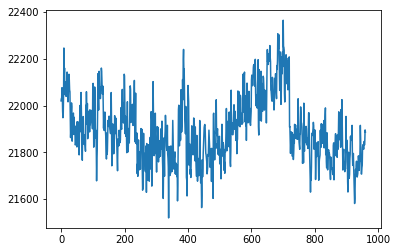

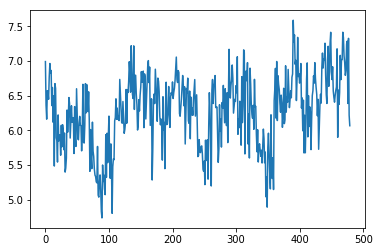

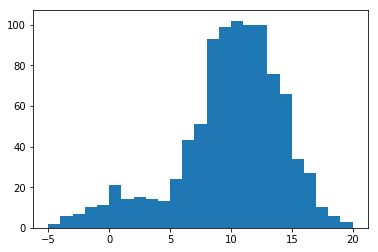

In [483]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [484]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [485]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

12.7% data discarded


In [486]:
scan_parameters[480:480+240] = 3

In [487]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

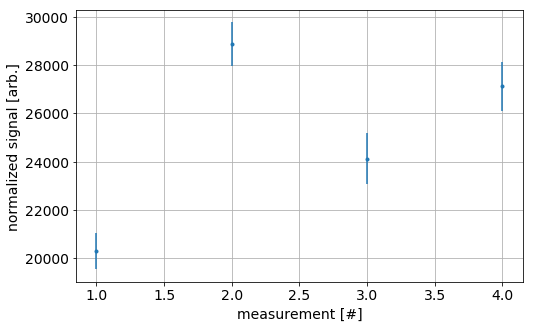

In [488]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('measurement [#]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

1 = all -25 dBm  
2 = J12 -12 dBm; J23 -25 dBm  
3 = J12 -25 dBm; J23 -9.35 dBm  
4 = J12 -12 dBm; J23 -9.35 dBm

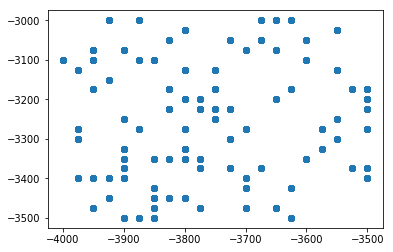

In [489]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan microwave powers with R2 F4 F1=7/2 DET
J12 @ -12 dBm source  
35 mW DET  

In [439]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [440]:
dset_idx = 16
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

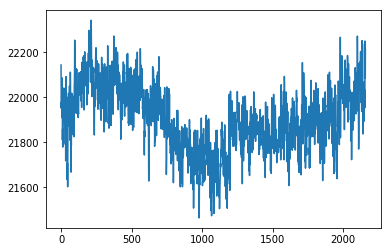

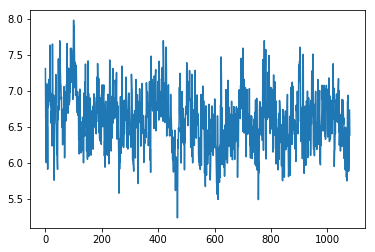

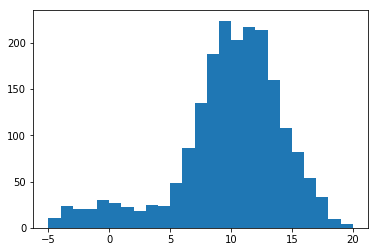

In [441]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [442]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [443]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

11.0% data discarded


In [444]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

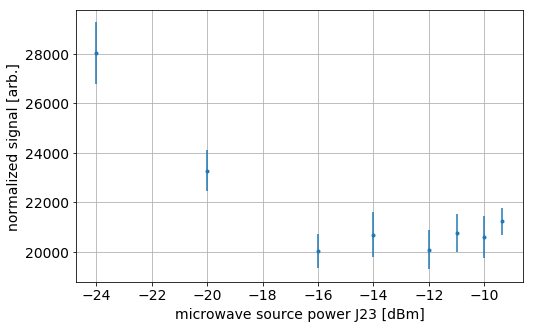

In [445]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power J23 [dBm]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

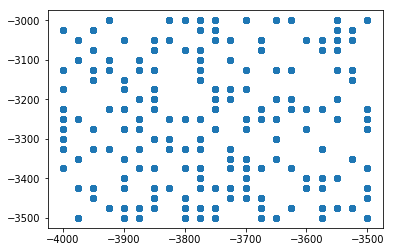

In [446]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan microwave powers with R2 F4 F1=7/2 DET
J23 @ -9.35 dBm source  
35 mW DET  

In [448]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [466]:
dset_idx = 17
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

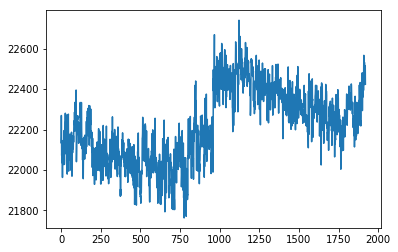

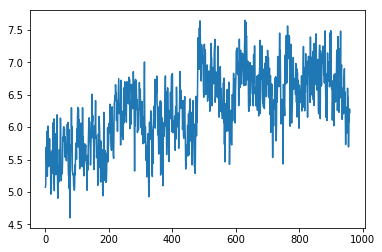

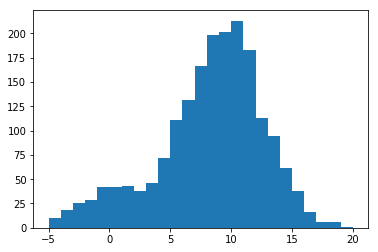

In [467]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [468]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [469]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

19.8% data discarded


In [470]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

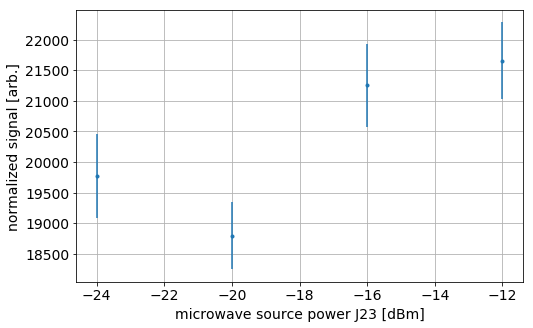

In [471]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power J23 [dBm]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

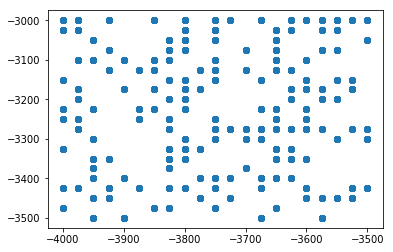

In [472]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan microwave powers with R2 F4 F1=7/2 DET
J12 @ -12 dBm source  
35 mW DET  

In [473]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [496]:
dset_idx = 18
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

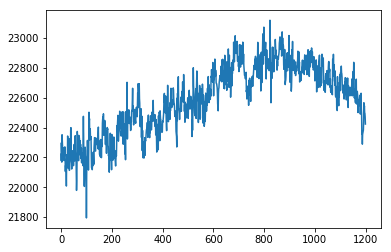

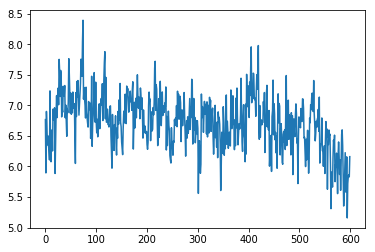

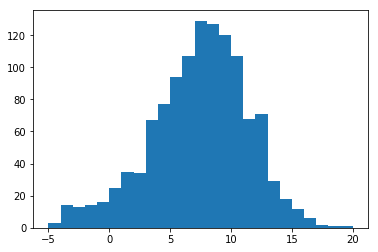

In [497]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [498]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [499]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

25.8% data discarded


In [500]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

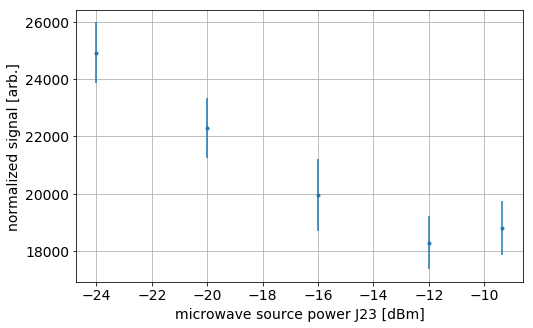

In [501]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('microwave source power J23 [dBm]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

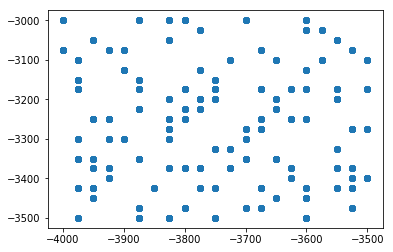

In [502]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan R1 F3 F1=5/2 DET
37 mW DET  

In [507]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [508]:
dset_idx = 19
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

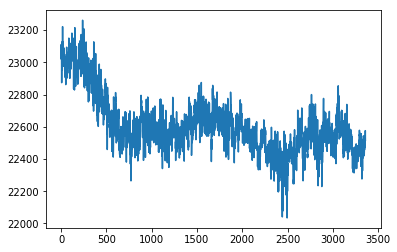

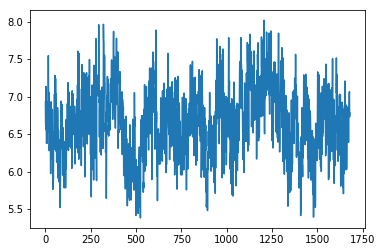

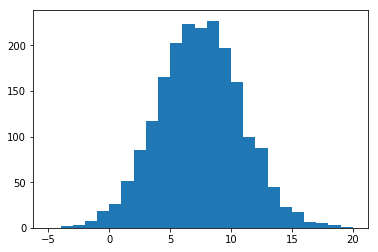

In [509]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [510]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [511]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

26.6% data discarded


In [512]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

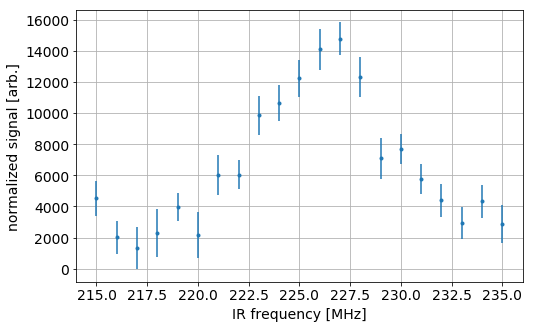

In [513]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

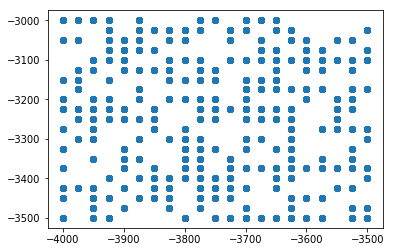

In [514]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

## Scan P2 F1 ratio with R1 F3 F1=5/2 DET and J12 & J23 microwaves
37 mW DET  
81 mW RC

In [141]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [142]:
dset_idx = 20
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

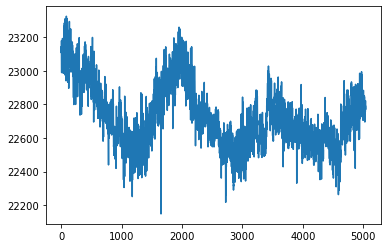

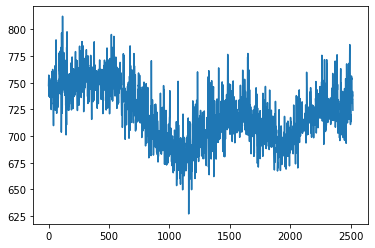

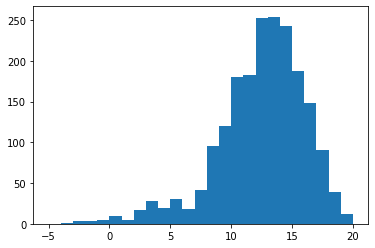

In [143]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [144]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 600

In [145]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

3.1% data discarded


In [146]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

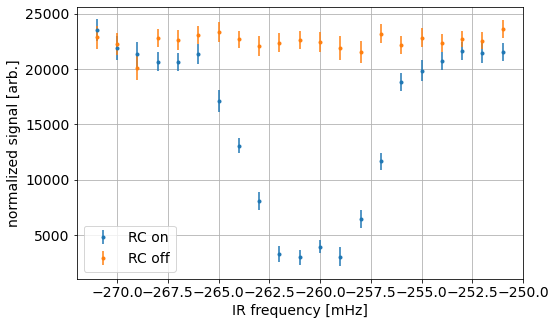

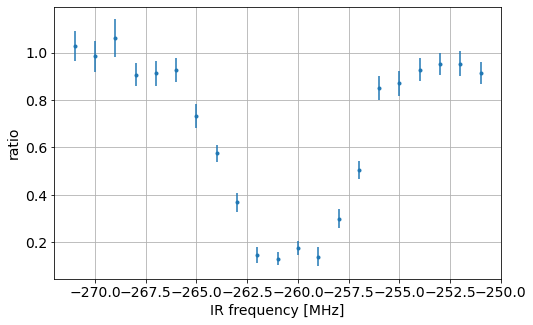

In [147]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [mHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [148]:
ratio

array([1.02874788, 0.98362396, 1.06075388, 0.90637797, 0.91157074,
       0.92649067, 0.73322309, 0.57586128, 0.36798513, 0.14740173,
       0.13114487, 0.17647636, 0.13919175, 0.3000194 , 0.5034233 ,
       0.85069995, 0.86948603, 0.92753684, 0.95268644, 0.95207071,
       0.91191999])

In [149]:
m = (bin_means == -262) | (bin_means == -261) | (bin_means == -260) | (bin_means == -259)
ratio[m].mean()

0.1485536755571987

In [150]:
np.sum(err**2)/np.sqrt(m.sum())

0.024848137690010833

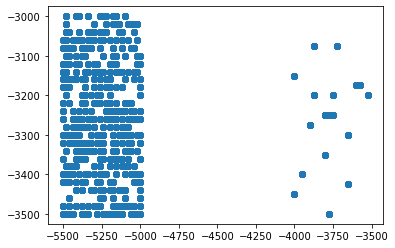

In [151]:
plt.scatter(data_devices['ZaberTMM']['x'],data_devices['ZaberTMM']['y'])

In [152]:
m = (bin_means == -262) | (bin_means == -261) | (bin_means == -260) | (bin_means == -259)
print(ratio[m].mean())
print(np.sqrt(np.sum(err[m]**2))/np.sqrt(m.sum()))

0.1485536755571987
0.03345732640979785


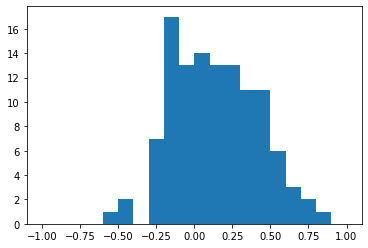

In [205]:
m = scan_parameters == -261
o = (fluorescence_integral/absorption_integral)[m & mask_sh_open]
# o = np.nanmean(o.reshape(-1,5), axis = 1)
c = (fluorescence_integral/absorption_integral)[m & mask_sh_closed]
# c = np.nanmean(c.reshape(-1,5), axis = 1)

plt.hist(o/c, bins = np.linspace(-1,1,21));

In [178]:
np.where(o/c < 0.1)

(array([  0,   1,   5,   6,   8,  11,  13,  14,  15,  18,  20,  21,  23,
         24,  25,  28,  33,  34,  41,  43,  45,  46,  47,  48,  51,  55,
         58,  62,  66,  68,  71,  73,  79,  81,  82,  83,  84,  86,  87,
         90,  95,  96,  98,  99, 100, 101, 104, 106, 107, 110, 111, 116,
        117, 119], dtype=int64),)

In [207]:
np.where((fluorescence_integral/absorption_integral) == o[8])

(array([617], dtype=int64),)

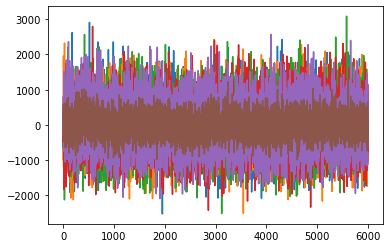

In [211]:
start = 611
plt.plot(pmt_data_norm[start:start+10:2].T)
plt.plot(pmt_data_norm[start:start+10:2].mean(axis = 0))

In [200]:
np.trapz(pmt_data_norm[603][slice_fli])

372323.7613333346

(array([ 1.,  1.,  8., 11., 19.,  9.,  8.,  0.,  1.,  1.]),
 array([-258691.05866667, -203270.91413333, -147850.7696    ,
         -92430.62506667,  -37010.48053333,   18409.664     ,
          73829.80853333,  129249.95306667,  184670.0976    ,
         240090.24213334,  295510.38666667]),
 <BarContainer object of 10 artists>)

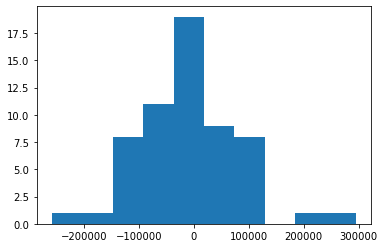

In [220]:
dat = pmt_data.copy()[mask_yag]
dat -= dat[:,slice_flm].mean(axis = 1)[:, np.newaxis]
plt.hist(np.trapz(dat[:,slice_fli], axis = 1))

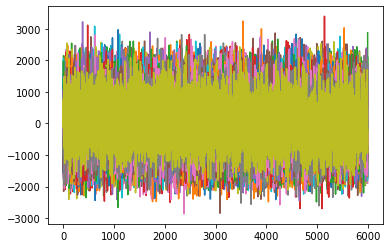

In [225]:
plt.plot(dat.T);

### Calculate Populations

In [274]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [275]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [276]:
T = 6.3
ρ_ini = np.zeros([67,67], dtype = 'complex')

for J in range(0,4):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()
ρ_ini = np.diag(ρ_ini.real)

In [280]:
pop_ini = ρ_ini[0].sum()
pop_gain = ρ_ini[J_slice(1)].sum()*0.85 + ρ_ini[J_slice(2)].sum()*0.78 + ρ_ini[J_slice(3)].sum()*0.82
pop_gain

0.7408943911968937

In [281]:
BrF0 = 0.337
BrF1 = 0.147

In [291]:
(pop_ini+pop_gain*(BrF0/(BrF1+BrF0)))/pop_ini

24.115516369134532

In [292]:
σ_pop_gain = np.sqrt((ρ_ini[J_slice(1)].sum()*0.03)**2 + (ρ_ini[J_slice(2)].sum()*0.03)**2 + (ρ_ini[J_slice(3)].sum()*0.04)**2)

In [293]:
σ_pop_gain*(BrF0/(BrF1+BrF0))/pop_ini

0.5708632702317302

ratio calculated from R0 F2

In [254]:
print(3 * (BrF0/BrF1) * (3.8 - 1) + 1)
print(3 * (BrF0/BrF1) * (0.17))

20.257142857142856
1.169183673469388


ratio calculated from R0 F1 and R0 F2

In [139]:
print(4*8.33 - 3*3.81)
print(np.sqrt(4**2*0.48**2 + 3**2*0.17**2) )

21.89
1.9865799757371965


In [140]:
BrF0/(BrF0 + BrF1)

0.6962809917355373